# MongoDB Benchmarks – Big Experiments

## Libraries

In [2]:
from fabric import ThreadingGroup, Connection
from chi import server, ssh
import os
import warnings
import time
import sys
sys.path.append('../../scripts')
from utilities import *
warnings.filterwarnings('ignore')


## Configurations

In [3]:
sshUser = "ubuntu"
server_ips = ["64.131.114.157"]
server_local_ips = {}
client_ips = ["64.131.114.158"]

storageType = {"HDD": "/HDD", "NVME": "/NVME_RAID-0"}
SERVER_WORKING_DIR = storageType["NVME"]


## Initialize environment

In [4]:
# These groups are for processing in parallel
serverConnections = [Connection(i, user=sshUser) for i in server_ips]
clientConnections = [Connection(i, user=sshUser) for i in client_ips]
allConnections = (serverConnections + clientConnections)
serverGroup = ThreadingGroup.from_connections(serverConnections)
clientGroup = ThreadingGroup.from_connections(clientConnections)
allGroup = ThreadingGroup.from_connections(allConnections)

# Get local IP for server
local_ips = serverGroup.run("hostname -I | cut -d ' ' -f 1", hide=True)
for i in local_ips:
    server_local_ips[i.host] = local_ips[i].stdout.strip()


In [4]:
# # Update & Upgrade latest packages
# allGroup.run(f"sudo apt update; sudo apt upgrade -y; sudo shutdown -r +1", hide=True)
# allGroup.close()


Wait for all server to come online after reboot

In [5]:
# # Buffer of reboot
# time.sleep(70)

# for ip in (server_ips + client_ips):
#     server.wait_for_tcp(ip, 22, timeout=1200)


## Datasets

Preparing test datasets on client nodes

In [6]:
# clientGroup.put("../scripts/initData.sh")
# clientGroup.run("bash initData.sh", hide=True)
# clientGroup.close()


## Benchmark server (MongoDB)

Prepare benchmark server

In [6]:
serverGroup.put("../../scripts/MongoDB/initMongoDBServer.sh")
serverGroup.run(f"sudo chmod -R 777 {SERVER_WORKING_DIR}; bash initMongoDBServer.sh {SERVER_WORKING_DIR} true", hide=True)
serverGroup.close()


## Benchmark client (XBench)
Prepare benchmark client

In [8]:
# clientGroup.put("../scripts/initXBenchClient.sh")
# clientGroup.run("bash initXBenchClient.sh", hide=True)
# clientGroup.close()


## Experiments - Settings

In [5]:
targetThreads = [1, 2, 4]
numClients = [i * len(client_ips) for i in targetThreads]


## Experiment – UNARY INSERT (SEQ)
**Perform experiments**

In [ ]:
runWorkload("INSERT_UNARY_SEQ", targetThreads, server_local_ips[server_ips[0]], 9491, "MongoDB", client_ips, 1000, 0, serverGroup, SERVER_WORKING_DIR, "ubuntu")


[Benchmark: 1] - Schedule workload on 1745833168
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1745833115 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1745833638
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1745833585 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1745834115
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1745834061 | Delta: 54
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1745834664
[Benchmark: 8] [Client: 64.131.114.158] - Time now: 1745834552 | Delta: 112


Socket exception: Connection reset by peer (54)
Socket exception: Connection reset by peer (54)
IOStream.flush timed out
Oops, unhandled type 3 ('unimplemented')
Socket exception: Connection reset by peer (54)
IOStream.flush timed out


**Visualization**

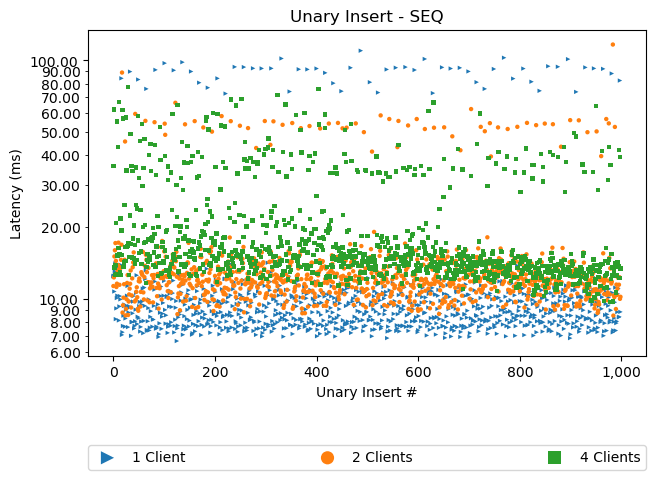

In [6]:
unaryPlots("INSERT_UNARY_SEQ", "MongoDB", targetThreads, client_ips, logScale=True)


## Experiment – BATCH INSERT (SEQ)
**Perform experiments**

In [7]:
runWorkload("INSERT_BATCH_SEQ", targetThreads, server_local_ips[server_ips[0]], 9491, "MongoDB", client_ips, 1000, 10, serverGroup, SERVER_WORKING_DIR, "ubuntu")


[Benchmark: 1] - Schedule workload on 1745857758
[Benchmark: 1] [Client: 64.131.114.158] - Time now: 1745857710 | Delta: 48
[Benchmark: 1] [Client: 64.131.114.158] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1745858248
[Benchmark: 2] [Client: 64.131.114.158] - Time now: 1745858200 | Delta: 48
[Benchmark: 2] [Client: 64.131.114.158] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1745859159
[Benchmark: 4] [Client: 64.131.114.158] - Time now: 1745859111 | Delta: 48
[Benchmark: 4] [Client: 64.131.114.158] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files


**Visualization**

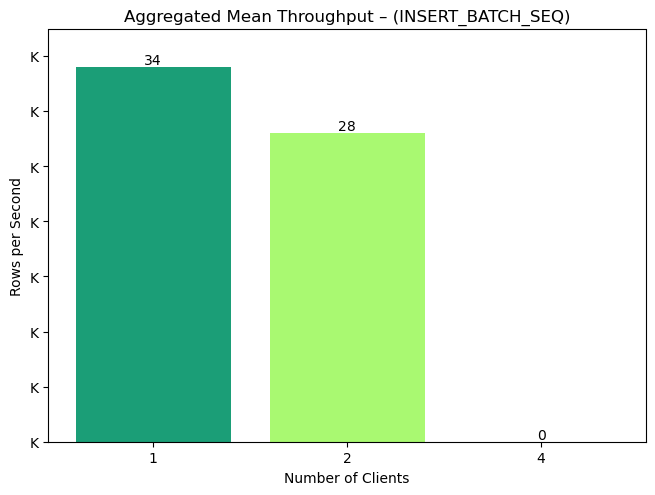

In [9]:
batchPlots("INSERT_BATCH_SEQ", "MongoDB", targetThreads, client_ips)


## Bootstrap Database

Reboot server to a fresh state to avoid becoming non-accessible from public network

In [18]:
# allGroup.run(f"sudo shutdown -r +1", hide=True)
# allGroup.close()

# # Buffer of reboot
# time.sleep(70)

# for ip in (server_ips + client_ips):
#     server.wait_for_tcp(ip, 22, timeout=1200)


<div class="alert alert-block alert-info">Note: This is required so that there's actual data for clients to query from</div>

In [19]:
# serverGroup.put("../scripts/restoreDB.sh")
# serverGroup.close()

# # Restore DB
# serverGroup.run(f"bash restoreDB.sh CHI@UC MongoDB {SERVER_WORKING_DIR}", hide=True)
# serverGroup.close()

# # Keep checking if job is done running in tmux window
# checkTmuxJobIsDone(serverGroup)


## Experiment – UNARY QUERY (SEQ)

**Perform experiments**

In [ ]:
runWorkload("QUERY_UNARY_SEQ", targetThreads, server_local_ips[server_ips[0]], 9491, "MongoDB", client_ips, 1000, 0, serverGroup, SERVER_WORKING_DIR, "ubuntu")


**Visualization**

In [ ]:
unaryPlots("QUERY_UNARY_SEQ", "MongoDB", targetThreads, client_ips, logScale=True)


## Experiment – UNARY QUERY (RAND)

**Perform experiments**

In [ ]:
runWorkload("QUERY_UNARY_RAND", targetThreads, server_local_ips[server_ips[0]], 9491, "MongoDB", client_ips, 1000, 0, serverGroup, SERVER_WORKING_DIR, "ubuntu")


**Visualization**

In [ ]:
unaryPlots("QUERY_UNARY_RAND", "MongoDB", targetThreads, client_ips)


## Experiment – BATCH QUERY (SEQ)

**Perform experiments**

In [ ]:
runWorkload("QUERY_BATCH_SEQ", targetThreads, server_local_ips[server_ips[0]], 9491, "MongoDB", client_ips, 100, 1000, serverGroup, SERVER_WORKING_DIR, "ubuntu")


**Visualization**

In [ ]:
batchPlots("QUERY_BATCH_SEQ", "MongoDB", targetThreads, client_ips, 100)


## Experiment – BATCH QUERY (RAND)

**Perform experiments**

In [ ]:
runWorkload("QUERY_BATCH_RAND", targetThreads, server_local_ips[server_ips[0]], 9491, "MongoDB", client_ips, 1000, 10, serverGroup, SERVER_WORKING_DIR, "ubuntu")


**Visualization**

In [ ]:
batchPlots("QUERY_BATCH_RAND", "MongoDB", targetThreads, client_ips)
